In [3]:
# Gerekli kütüphanelerin yüklenmesi ve temel ayarlar
import kagglehub
import numpy as np  # Sayısal işlemler için
import pandas as pd  # Veri işleme ve CSV okuma
import os
import warnings
import matplotlib.pyplot as plt  # Grafik çizimi
import seaborn as sns  # Gelişmiş görselleştirme

warnings.filterwarnings("ignore", category=FutureWarning)

# MovieLens 20M Veri Seti Analizi

Bu notebook'ta MovieLens 20M veri seti üzerinde temel veri analizi ve görselleştirme işlemleri yapılacaktır.

In [4]:
# Kaggle veri setinin indirilmesi
data_folder = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Veri seti başarıyla indirildi:", data_folder)


Veri seti başarıyla indirildi: /Users/yusufoztop/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


## 1. CSV Dosyalarının Okunması

Veri setindeki dosyalar pandas ile okunup DataFrame'e dönüştürülüyor.

In [5]:
# Dosya yolu
ratings = pd.read_csv(f"{data_folder}/rating.csv")
movies = pd.read_csv(f"{data_folder}/movie.csv")
tags = pd.read_csv(f"{data_folder}/tag.csv")
links = pd.read_csv(f"{data_folder}/link.csv")
genome_tags = pd.read_csv(f"{data_folder}/genome_tags.csv")
genome_scores = pd.read_csv(f"{data_folder}/genome_scores.csv")

In [6]:
# Zaman damgası kolonlarını atıyoruz
CleanRatings = ratings.drop(columns=["timestamp"])
CleanTags = tags.drop(columns=["timestamp"])

# Ratings ve movies birleştiriliyor
df = CleanRatings.merge(movies, on="movieId")

# Tag'leri birleştiriyoruz
TagsAdd = (
    CleanTags
    .groupby("movieId")["tag"]
    .apply(lambda x: ", ".join(x.dropna().astype(str)))
    .reset_index()
    )

df = df.merge(TagsAdd, on="movieId", how="left")

## 2. Keşifsel Veri Analizi (EDA) ve Temizlik

Veri setinin genel yapısı ve eksik değerler inceleniyor.

In [7]:
# datasetin ilk 10 satiri
df.head()

,userId,movieId,rating,title,genres,tag
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,"time travel, adapted from:book, board game, ch..."
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"children, Santa Claus, dystopia, abused childr..."
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,"post-apocalyptic, psychology, time travel, Bra..."
3,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"atmospheric, psychology, serial killer, BFI mo..."
4,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"organized crime, twist ending, twists & turns,..."


In [8]:
df.size

120001578

In [9]:
print("\nEksik değerlerin sayısı:")
print(df.isnull().sum())


Eksik değerlerin sayısı:
userId          0
movieId         0
rating          0
title           0
genres          0
tag        145693
dtype: int64


In [10]:
# En çok puan alan 10 film
MostRated = (
    df.groupby("title")["rating"]
      .count()
      .sort_values(ascending=False)
)

print("\nEn çok puan alan 10 film:")
print(MostRated.head(10))


En çok puan alan 10 film:
title
Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Name: rating, dtype: int64


In [11]:
# 1. genres kolonunda boş değer var mı?
print("Boş değer sayısı:", df["genres"].isna().sum())

Boş değer sayısı: 0


In [12]:
# === 2. Genre Kolonunu Ayır ===
movies["genres_split"] = movies["genres"].apply(
    lambda x: [] if x == "(no genres listed)" else x.split("|")
)
movies["genre_count"] = movies["genres_split"].apply(len)  # no genres listed -> 0

# === TEMEL SAYISAL İSTATİSTİKLER ===
all_genres = pd.Series([g for sublist in movies["genres_split"] for g in sublist])
print("🔹 Toplam farklı genre sayısı:", all_genres.nunique())
print("🔹 Film başına minimum genre sayısı:", movies["genre_count"].min())
print("🔹 Film başına maksimum genre sayısı:", movies["genre_count"].max())
print("🔹 Ortalama genre sayısı:", movies["genre_count"].mean())
print("🔹 Medyan genre sayısı:", movies["genre_count"].median())

print("\n🔹 Film başına genre dağılımı:")
print(movies["genre_count"].value_counts().sort_index())

genre_counts = all_genres.value_counts()
print("\n🔹 En çok geçen genre:\n", genre_counts.head(1))
print("\n🔹 En az geçen genre:\n", genre_counts.tail(1))

# === KULLANICI DAVRANIŞI ===
ratings_with_genres = ratings.merge(
    movies[["movieId", "genres_split"]],
    on="movieId",
    how="left"
)

user_genre_sets = {}

for row in ratings_with_genres.itertuples(index=False):
    user = row.userId
    genres = row.genres_split
    if isinstance(genres, list):
        if user not in user_genre_sets:
            user_genre_sets[user] = set()
        user_genre_sets[user].update(genres)

user_genres = pd.Series({u: len(gs) for u, gs in user_genre_sets.items()})

print("\n🔹 Ortalama kullanıcı tür çeşitliliği:", user_genres.mean())
print("🔹 En çok tür puanlayan kullanıcı (ID, sayı):", user_genres.idxmax(), user_genres.max())
print("🔹 En az tür puanlayan kullanıcı (ID, sayı):", user_genres.idxmin(), user_genres.min())

🔹 Toplam farklı genre sayısı: 19
🔹 Film başına minimum genre sayısı: 0
🔹 Film başına maksimum genre sayısı: 10
🔹 Ortalama genre sayısı: 1.9854828066573795
🔹 Medyan genre sayısı: 2.0

🔹 Film başına genre dağılımı:
genre_count
0       246
1     10583
2      8809
3      5330
4      1724
5       477
6        83
7        20
8         5
10        1
Name: count, dtype: int64

🔹 En çok geçen genre:
 Drama    13344
Name: count, dtype: int64

🔹 En az geçen genre:
 IMAX    196
Name: count, dtype: int64

🔹 Ortalama kullanıcı tür çeşitliliği: 16.3785462081116
🔹 En çok tür puanlayan kullanıcı (ID, sayı): 11 19
🔹 En az tür puanlayan kullanıcı (ID, sayı): 30293 5


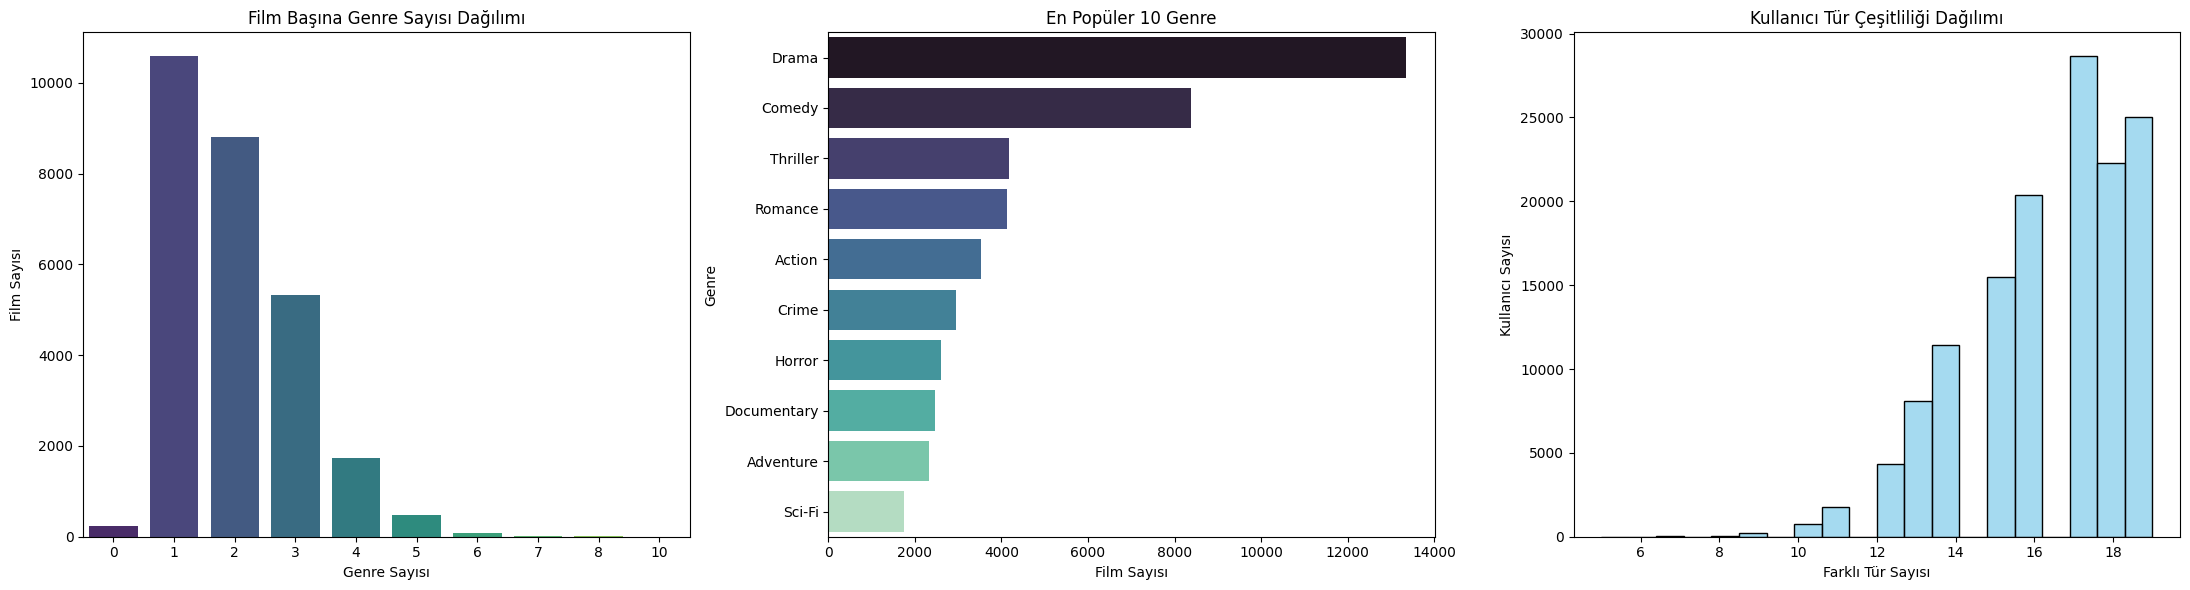

In [13]:

# "(no genres listed)" hariç tut
valid_genre_counts = genre_counts[genre_counts.index != "(no genres listed)"]

# === Subplot ayarları ===
fig, axes = plt.subplots(1, 3, figsize=(22,6))

# === 1. Film başına genre sayısı dağılımı (0 dahil) ===
genre_count_values = movies["genre_count"].value_counts().sort_index()
sns.barplot(
    x=genre_count_values.index,
    y=genre_count_values.values,
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title("Film Başına Genre Sayısı Dağılımı")
axes[0].set_xlabel("Genre Sayısı")
axes[0].set_ylabel("Film Sayısı")

# === 2. En popüler 10 genre ===
sns.barplot(
    x=valid_genre_counts.head(10).values,
    y=valid_genre_counts.head(10).index,
    palette="mako",
    ax=axes[1]
)
axes[1].set_title("En Popüler 10 Genre")
axes[1].set_xlabel("Film Sayısı")
axes[1].set_ylabel("Genre")

# === 3. Kullanıcı Tür Çeşitliliği Dağılımı ===
sns.histplot(
    user_genres,
    bins=20,
    kde=False,
    color="skyblue",
    ax=axes[2]
)
axes[2].set_title("Kullanıcı Tür Çeşitliliği Dağılımı")
axes[2].set_xlabel("Farklı Tür Sayısı")
axes[2].set_ylabel("Kullanıcı Sayısı")

plt.tight_layout()
plt.show()


In [14]:
uniqueGenres = df['genres'].unique()


for x in uniqueGenres:
  print(x)
  print('-----')

Adventure|Children|Fantasy
-----
Adventure|Drama|Fantasy|Mystery|Sci-Fi
-----
Mystery|Sci-Fi|Thriller
-----
Mystery|Thriller
-----
Crime|Mystery|Thriller
-----
Action|Adventure|Comedy|Crime
-----
Action|Drama|Romance|War
-----
Comedy
-----
Drama|Horror
-----
Action|Adventure|Sci-Fi
-----
Action|Crime|Drama|Thriller
-----
Comedy|Crime|Drama|Thriller
-----
Crime|Drama
-----
Drama
-----
Action|Comedy|Crime|Fantasy
-----
Action|Sci-Fi|Thriller
-----
Action|Sci-Fi
-----
Crime|Horror|Thriller
-----
Action|Adventure|Fantasy
-----
Adventure|Children|Fantasy|Musical
-----
Adventure|Drama|Sci-Fi
-----
Action|Crime|Thriller
-----
Comedy|Crime
-----
Drama|War
-----
Children|Drama|Sci-Fi
-----
Adventure|Comedy|Fantasy
-----
Action|Adventure
-----
Action|Adventure|Horror|Sci-Fi
-----
Action|Adventure|Western
-----
Action|Drama|War
-----
Horror|Sci-Fi
-----
Action|Adventure|Comedy|Fantasy|Horror
-----
Crime|Horror
-----
Comedy|Drama
-----
Action|Crime|Romance|Thriller
-----
Horror
-----
Adventure|Dra

In [15]:
import pandas as pd

# Split genres into rows
movies_expanded = movies.assign(genre=movies['genres'].str.split('|')).explode('genre')

# Mark missing genres (MovieLens usually uses "(no genres listed)")
missing_movies = movies[movies['genres'] == "(no genres listed)"]

# Step 1: Find user -> genre preference
# Merge ratings with expanded genres
user_genres = ratings.merge(movies_expanded, on="movieId")

# Count how many times each user rated each genre
user_genre_counts = (
    user_genres.groupby(['userId', 'genre'])
    .size()
    .reset_index(name="count")
)

# Step 2: Find top genre for each user
user_top_genre = (
    user_genre_counts.sort_values(['userId', 'count'], ascending=[True, False])
    .drop_duplicates('userId')  # keep only the top one
    .rename(columns={"genre": "top_genre"})
)

# Step 3: Assign genres for missing movies
# Merge ratings of missing movies with users' top genres
missing_with_users = ratings.merge(
    missing_movies[['movieId']], on="movieId"
).merge(user_top_genre[['userId', 'top_genre']], on="userId")

# Find the most common top_genre among watchers of each missing movie
imputed_genres = (
    missing_with_users.groupby('movieId')['top_genre']
    .agg(lambda x: x.value_counts().idxmax())  # most common genre
    .reset_index()
)

# Step 4: Replace missing genres
movies_filled = movies.merge(imputed_genres, on="movieId", how="left")
movies_filled['final_genres'] = movies_filled['genres']
movies_filled.loc[movies_filled['genres'] == "(no genres listed)", 'final_genres'] = \
    movies_filled.loc[movies_filled['genres'] == "(no genres listed)", 'top_genre']

# Now movies_filled['final_genres'] contains original or imputed genre


In [16]:
# imputed_genres looks like: movieId | top_genre
# df looks like: movieId | ... | genres

# Merge imputed genres onto your df
df = df.merge(imputed_genres, on="movieId", how="left")

# Add new column for imputed genres
# If a movie already has genres, keep them
# If it's "(no genres listed)", use top_genre
df["imputedGenres"] = df["genres"]
df.loc[df["genres"] == "(no genres listed)", "imputedGenres"] = df["top_genre"]

# Optionally drop the helper column
df = df.drop(columns=["top_genre"])


In [17]:
df

,userId,movieId,rating,title,genres,tag,imputedGenres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,"time travel, adapted from:book, board game, ch...",Adventure|Children|Fantasy
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"children, Santa Claus, dystopia, abused childr...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,"post-apocalyptic, psychology, time travel, Bra...",Mystery|Sci-Fi|Thriller
3,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"atmospheric, psychology, serial killer, BFI mo...",Mystery|Thriller
4,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"organized crime, twist ending, twists & turns,...",Crime|Mystery|Thriller
...,...,...,...,...,...,...,...
20000258,138493,68954,4.5,Up (2009),Adventure|Animation|Children|Drama,"emotional, friendship, Watched, Bechdel Test:F...",Adventure|Animation|Children|Drama
20000259,138493,69526,4.5,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX,"better method AI, needed more autobots, stop u...",Action|Adventure|Sci-Fi|IMAX
20000260,138493,69644,3.0,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...,"2D characters, emotionless, lacks logic, Anima...",Action|Adventure|Animation|Children|Comedy|Rom...
20000261,138493,70286,5.0,District 9 (2009),Mystery|Sci-Fi|Thriller,"action, alien invasion, aliens, sci-fi, social...",Mystery|Sci-Fi|Thriller


In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

# 1. imputedGenres'i liste haline getir
df["imputedGenres_list"] = df["imputedGenres"].fillna("").astype(str).str.split("|")

# 2. MultiLabelBinarizer ile encode et
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df["imputedGenres_list"])

# 3. Encode edilmiş dataframe oluştur
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df.index)

# 4. Orijinal df ile birleştir
df = pd.concat([df, genre_df], axis=1)

print(df.head())


   userId  movieId  rating                                              title  \
0       1        2     3.5                                     Jumanji (1995)   
1       1       29     3.5  City of Lost Children, The (Cité des enfants p...   
2       1       32     3.5          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3       1       47     3.5                        Seven (a.k.a. Se7en) (1995)   
4       1       50     3.5                         Usual Suspects, The (1995)   

                                   genres  \
0              Adventure|Children|Fantasy   
1  Adventure|Drama|Fantasy|Mystery|Sci-Fi   
2                 Mystery|Sci-Fi|Thriller   
3                        Mystery|Thriller   
4                  Crime|Mystery|Thriller   

                                                 tag  \
0  time travel, adapted from:book, board game, ch...   
1  children, Santa Claus, dystopia, abused childr...   
2  post-apocalyptic, psychology, time travel, Bra...   
3  atmospheric, ps

In [19]:
df.head()

,userId,movieId,rating,title,genres,tag,imputedGenres,imputedGenres_list,Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,"time travel, adapted from:book, board game, ch...",Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"children, Santa Claus, dystopia, abused childr...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",0,1,...,0,0,0,0,1,0,1,0,0,0
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,"post-apocalyptic, psychology, time travel, Bra...",Mystery|Sci-Fi|Thriller,"[Mystery, Sci-Fi, Thriller]",0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"atmospheric, psychology, serial killer, BFI mo...",Mystery|Thriller,"[Mystery, Thriller]",0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"organized crime, twist ending, twists & turns,...",Crime|Mystery|Thriller,"[Crime, Mystery, Thriller]",0,0,...,0,0,0,0,1,0,0,1,0,0


In [20]:
import re

def extract_year(title):
    years = re.findall(r'\d{4}', str(title))  # bütün 4 haneli sayıları bul
    if years:
        return int(years[-1])  # en sondakini yıl kabul et
    return None

df["year"] = df["title"].apply(extract_year)

# Şimdi sadece en sondaki " (YYYY)" kısmını temizle
df["clean_title"] = df["title"].str.replace(r'\s*\(\s*(?:19|20)\d{2}\s*\)\s*$', '', regex=True).str.strip()

In [21]:
df

,userId,movieId,rating,title,genres,tag,imputedGenres,imputedGenres_list,Action,Adventure,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,clean_title
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,"time travel, adapted from:book, board game, ch...",Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,1,...,0,0,0,0,0,0,0,0,1995.0,Jumanji
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"children, Santa Claus, dystopia, abused childr...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",0,1,...,0,0,1,0,1,0,0,0,1995.0,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,"post-apocalyptic, psychology, time travel, Bra...",Mystery|Sci-Fi|Thriller,"[Mystery, Sci-Fi, Thriller]",0,0,...,0,0,1,0,1,1,0,0,1995.0,Twelve Monkeys (a.k.a. 12 Monkeys)
3,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"atmospheric, psychology, serial killer, BFI mo...",Mystery|Thriller,"[Mystery, Thriller]",0,0,...,0,0,1,0,0,1,0,0,1995.0,Seven (a.k.a. Se7en)
4,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"organized crime, twist ending, twists & turns,...",Crime|Mystery|Thriller,"[Crime, Mystery, Thriller]",0,0,...,0,0,1,0,0,1,0,0,1995.0,"Usual Suspects, The"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20000258,138493,68954,4.5,Up (2009),Adventure|Animation|Children|Drama,"emotional, friendship, Watched, Bechdel Test:F...",Adventure|Animation|Children|Drama,"[Adventure, Animation, Children, Drama]",0,1,...,0,0,0,0,0,0,0,0,2009.0,Up
20000259,138493,69526,4.5,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX,"better method AI, needed more autobots, stop u...",Action|Adventure|Sci-Fi|IMAX,"[Action, Adventure, Sci-Fi, IMAX]",1,1,...,1,0,0,0,1,0,0,0,2009.0,Transformers: Revenge of the Fallen
20000260,138493,69644,3.0,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...,"2D characters, emotionless, lacks logic, Anima...",Action|Adventure|Animation|Children|Comedy|Rom...,"[Action, Adventure, Animation, Children, Comed...",1,1,...,0,0,0,1,0,0,0,0,2009.0,Ice Age: Dawn of the Dinosaurs
20000261,138493,70286,5.0,District 9 (2009),Mystery|Sci-Fi|Thriller,"action, alien invasion, aliens, sci-fi, social...",Mystery|Sci-Fi|Thriller,"[Mystery, Sci-Fi, Thriller]",0,0,...,0,0,1,0,1,1,0,0,2009.0,District 9


In [22]:
df.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres', 'tag',
       'imputedGenres', 'imputedGenres_list', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'clean_title'],
      dtype='object')

In [47]:
# === 0. Kütüphaneler ===
import pandas as pd
import numpy as np
import faiss

# === 1. Tekil filmleri al ===
unique_movies = df.drop_duplicates(subset=["movieId"]).reset_index(drop=True)

# === 2. Year feature'ını normalize et (0-1 arası) ===
year_min = unique_movies['year'].min()
year_max = unique_movies['year'].max()
unique_movies['year_norm'] = (unique_movies['year'] - year_min) / (year_max - year_min)

# === 3. Genome scores ekleme ===
# genome_scores.csv: movieId, tagId, relevance
# pivot: movieId x tagId
genome_pivot = genome_scores.pivot(index="movieId", columns="tagId", values="relevance").fillna(0)

# genome pivot ile film tablosunu birleştir
unique_movies = unique_movies.set_index("movieId").join(genome_pivot, how="left").fillna(0)
unique_movies = unique_movies.reset_index()

# === 4. Feature matrix ===
# Genre one-hot + normalize year + genome scores
feature_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 
                'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year_norm']

# genome tag feature kolonları
tag_cols = [c for c in unique_movies.columns if isinstance(c, int)]  # pivot tagId kolonları

all_features = feature_cols + tag_cols

X_features = unique_movies[all_features].to_numpy().astype("float32").copy()  # FAISS için float32 & C-contiguous

# === 5. FAISS index oluştur ===
d = X_features.shape[1]
index = faiss.IndexFlatIP(d)   # inner product
faiss.normalize_L2(X_features)
index.add(X_features)
print("FAISS index hazır:", index.ntotal, "film yüklendi.")

# === 6. Öneri fonksiyonu ===
def recommend_movies_by_title(title, top_n=10):
    if title not in unique_movies["title"].values:
        return f"'{title}' bulunamadı."
    
    idx = unique_movies[unique_movies["title"] == title].index[0]
    xq = X_features[idx].reshape(1, -1)
    faiss.normalize_L2(xq)
    
    # top_n + 5 alıp kendisini çıkaracağız
    distances, indices = index.search(xq, top_n + 5)
    
    recs = unique_movies.iloc[indices[0]][["movieId", "title", "genres"]].copy()
    
    # Kendisi varsa çıkar
    recs = recs[recs["title"] != title].reset_index(drop=True)
    
    # Sadece top_n al
    recs = recs.head(top_n)
    
    # similarity skorlarını ekle
    recs["similarity"] = distances[0][:len(recs)]
    
    return recs


FAISS index hazır: 26744 film yüklendi.


In [49]:

# === 7. Test ===
print(recommend_movies_by_title("Jumanji (1995)", top_n=5))


   movieId                                        title  \
0     2054              Honey, I Shrunk the Kids (1989)   
1    40851                               Zathura (2005)   
2     2429                      Mighty Joe Young (1998)   
3    56915  Water Horse: Legend of the Deep, The (2007)   
4     1848                        Borrowers, The (1997)   

                                     genres  similarity  
0  Adventure|Children|Comedy|Fantasy|Sci-Fi    1.000000  
1         Action|Adventure|Children|Fantasy    0.870646  
2   Action|Adventure|Drama|Fantasy|Thriller    0.833993  
3                Adventure|Children|Fantasy    0.826441  
4         Adventure|Children|Comedy|Fantasy    0.822044  


In [50]:

# FAISS index
faiss.write_index(index, "movies.index")

# Feature matrix
np.save("features.npy", X_features)

# Film bilgileri
unique_movies.to_pickle("movies_meta.pkl")